In [1]:
data_folder = "D:\\repos\\desafio-spike-data"

# Pregunta 1

In [2]:
import pandas as pd
cmg_real = pd.read_csv(os.path.join(data_folder, "costo_marginal_real.csv"))
cmg_prog = pd.read_csv(os.path.join(data_folder, "costo_marginal_programado.csv"))
cmg_prog = cmg_prog.rename(columns={"mnemotecnico_barra": "barra_mnemotecnico", "costo": "cmg_prog", "nombre_barra": "nombre_barra_prog"})
cmg_real = cmg_real.rename(columns={"costo_en_dolares": "cmg_real", "costo_en_pesos": "cmg_real_clp", "nombre": "nombre_barra_real"})
print("nro barras real: {}".format(len(cmg_real["barra_mnemotecnico"].unique())))
print("nro barras prog: {}".format(len(cmg_prog["barra_mnemotecnico"].unique())))

nro barras real: 1020
nro barras prog: 239


In [3]:
#Las barras de ambos conjuntos no coinciden. Se considera la intersección de ambos.
costo_marginal = pd.merge(cmg_prog, cmg_real,  how='inner', left_on=['barra_mnemotecnico','fecha', 'hora'], right_on = ['barra_mnemotecnico','fecha', 'hora'])
# Y checkeamos que no existan valores NaN
costo_marginal.isnull().sum(axis=0)

barra_mnemotecnico               0
nombre_barra_prog                0
fecha                            0
hora                             0
cmg_prog                         0
barra_referencia_mnemotecnico    0
cmg_real                         0
cmg_real_clp                     0
nombre_barra_real                0
dtype: int64

In [4]:
print("Cantidad de barras finales: {}".format(len(costo_marginal["barra_mnemotecnico"].unique())))
print("Fecha inicial: {}".format(costo_marginal["fecha"].min()))
print("Fecha final: {}".format(costo_marginal["fecha"].max()))

Cantidad de barras finales: 220
Fecha inicial: 2019-01-01
Fecha final: 2019-06-30


In [5]:
# Valores resumen
costo_marginal[["cmg_prog", "cmg_real"]].describe()

,cmg_prog,cmg_real
count,913388.000000,913388.000000
mean,61.888004,58.566654
std,23.806896,23.276453
min,-12.113677,0.000000
25%,49.981588,48.440000
50%,55.057527,53.330000
75%,64.181228,60.890000
max,610.600000,791.140000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022400419A90>,
      dtype=object)

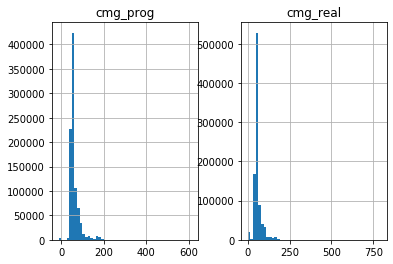

In [6]:
# Distribución de los valores
costo_marginal[["cmg_prog", "cmg_real"]].hist(bins=50)

In [7]:
# Outliers
(costo_marginal[["cmg_prog", "cmg_real"]] > 400).sum()

cmg_prog    54
cmg_real    12
dtype: int64

De acuerdo a los supuestos (unión de los conjuntos de barras y eliminación de valores NaN), existe un total de 220 barras analizadas. Como se pudo ver, las barras en los costos reales son distintas a las de los costos programados (barras con costos reales sin costos programados y viceversa). De esta forma el total de barras consideradas son un 22% de las barras con costos reales, y un 92% de las barras con costos programados.

De la descripción de la base (valores resumen) y los histogramas, se puede ver que los valores rondan los 50USD/MWh. La cola de distribución se extiende más hacia valores mayores, y no tanto hacia los menores (aproximadamente el percentil 25 está 5 puntos abajo, mientras que el percentil 75 está 10 puntos por encima). Existen algunos outliers superiores que problamente se deban a errores de lectura/escritura ya que no existen centrales que fijen costos tan altos en la red y a que es una cantidad muy pequeña o a costos de fallas.

# Pregunta 2

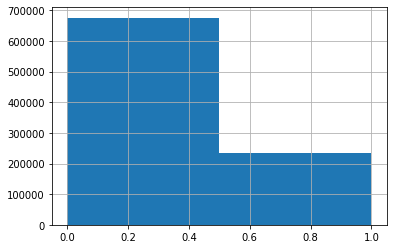

In [37]:
costo_marginal["desviacion"] = costo_marginal["cmg_real"] - costo_marginal["cmg_prog"]
costo_marginal["desviacion_pct"] = costo_marginal["desviacion"] / costo_marginal["cmg_prog"]
costo_marginal["desviacion_cat"] = (abs(costo_marginal["desviacion_pct"]) > 0.15).astype(int)
# Nota: "desviacion_cat" no se coloca como pd.Categorical() para poder analizar mas facilmente la temporalidad

# Comportamiento de "desviacion_cat"
costo_marginal["desviacion_cat"].hist(bins=2)

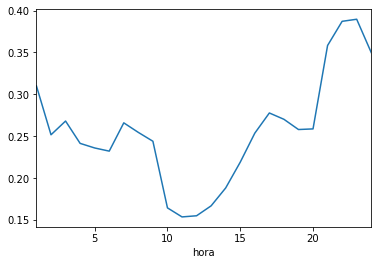

In [36]:
costo_marginal.groupby(["hora"])["desviacion_cat"].mean().plot()

Del histograma es posible ver que aproximadamente un tercio de los valores de la desviación de los costos reales están dentro del rango de 15% respecto de los programados. Mas aún, del segundo gráfico, en promedio a mediodía se tienen menores desviaciones respecto a los costos programados, mientras que cerca de medianoche esta desviación aumenta.

Notar que en el segundo gráfico hay barras con fechas que tienen 25 horas. Esto se corrige para poder crear fechas en formato datetime que ayudarían a tener un mejor análisis.

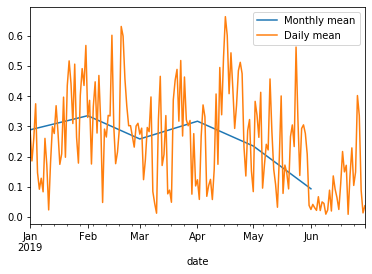

In [9]:
# Se elimina hora 25
costo_marginal = costo_marginal[costo_marginal["hora"] < 25]
# Se agrega además columna para fecha como datetime necesaria para análisis posterirores
costo_marginal["date"] = pd.to_datetime(costo_marginal["fecha"]+' '+(costo_marginal["hora"]-1).map('{:02}'.format)+':00:00', format='%Y-%m-%d %H:%M:%S')

import matplotlib.pyplot as plt
costo_marginal.set_index("date")["desviacion_cat"].groupby(pd.Grouper(freq='M')).mean().plot(label="Monthly mean")
costo_marginal.set_index("date")["desviacion_cat"].groupby(pd.Grouper(freq='D')).mean().plot(label="Daily mean")
plt.legend()

In [10]:
costo_marginal.set_index("date")["desviacion_cat"].groupby(pd.Grouper(freq='M')).count()

date
2019-01-31    165168
2019-02-28    149184
2019-03-31    165912
2019-04-30    152640
2019-05-31    157728
2019-06-30    122544
Freq: M, Name: desviacion_cat, dtype: int64

De este último gráfico, se puede ver que Junio presenta el mes con menores desviaciones, mientras que Febrero posee las mayores desviaciones. Sin embargo, la cantidad de datos por mes puede afectar levemente este análisis, particularmente para Junio que presenta menos datos que los otros meses. Una ponderación simple podría corregir esto.

Nota: si bien el promedio de variables categóricas no es teoricamente correcto, ayuda a conocer el comportamiento general de los valores particularmente en este caso. Y dado que se pide explícitamente el análisis sobre la variable "desviacion_cat", se decidió hacer así.

# Pregunta 3

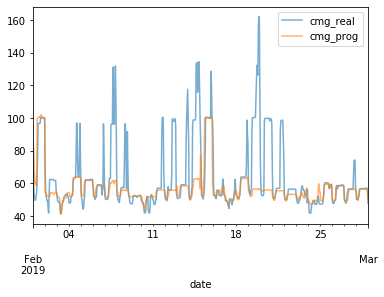

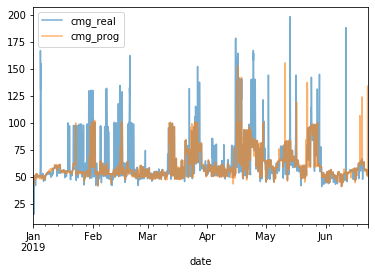

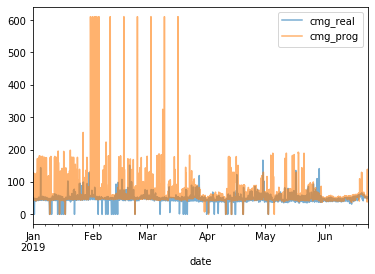

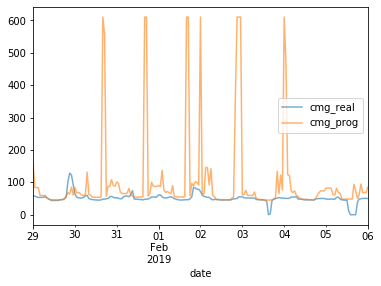

In [11]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
   """Función para graficar cosots de una barra entre dos fechas
   Params: 
   codigo_barra: String.
   fecha_inicial: String en formato datetime 'YYYY-MM-DD HH:MM:SS'
   fecha_final: String en formato datetime 'YYYY-MM-DD HH:MM:SS'
   """
   bar_filt = (costo_marginal["barra_mnemotecnico"] == codigo_barra) 
   date_filt = (costo_marginal["date"] >= fecha_inicial) & (costo_marginal["date"] <= fecha_final)
   costo_marginal[bar_filt & date_filt][["date", "cmg_real", "cmg_prog"]].plot(x='date', alpha=0.6)

time_plot_costo_barra("BA03T002SE002T002", "2019-02", "2019-03")
time_plot_costo_barra("BA03T002SE002T002", "2019-01", "2019-06-23")
time_plot_costo_barra("BA01T002SE026T002", "2019-01", "2019-06-23")
time_plot_costo_barra("BA01T002SE026T002", "2019-01-29", "2019-02-06")

De los gráficos seleccionados es posible ver que los valores están en torno a los 50USD/MWh tal como se analizó en la pregunta 1. La volatilidad de los valores al parecer depende de cada barra. En el caso del tercer gráfico los costos programados llegan a un valor fijo máximo en algunos momentos (apox. 600). Probablemente se deba a un costo de falla del sistema obtenido de las simulaciones.

Usar un gráfico de series de tiempo para encontrar etiquetas con valor cero no es eficiente. Por esto se realiza lo siguiente para encontrar la barra con costo real 0:

In [12]:
# identificar y eliminar barra cmg_real 0
grpd_sum_cmg_real = costo_marginal[["barra_mnemotecnico", "cmg_real"]].groupby(["barra_mnemotecnico"]).sum()
grpd_sum_cmg_real[grpd_sum_cmg_real['cmg_real'] == 0]

,cmg_real
barra_mnemotecnico,
BA01G049SE001G049,0.0


In [13]:
# Se elimina la barra
costo_marginal = costo_marginal[costo_marginal["barra_mnemotecnico"] != "BA01G049SE001G049"]

# Pregunta 4

## Punto 1

In [14]:
base_pred = pd.read_csv(os.path.join(data_folder, "base_para_prediccion.csv"))
base_pred.describe(include='all')

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779,112779,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
unique,29,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SE028T002,2019-04-06 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4345,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,NaN,NaN,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,NaN,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,NaN,NaN,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,NaN,NaN,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,NaN,NaN,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500


In [15]:
base_pred = base_pred.fillna(0) # Se asume que no se está generando (valor 0) cuando no existe valor (NaN)

In [16]:
print("Cantidad de datos: {}".format(len(base_pred)))
print("Fechas desde {} a {}".format(base_pred["fecha"].iloc[0], base_pred["fecha"].iloc[-1]))

Cantidad de datos: 112779
Fechas desde 2019-01-04 00:00:00 UTC a 2019-06-30 00:00:00 UTC


Existen 12 variables numéricas (11 continuas y una entera (n_barras)), 2 referentes a la fecha/hora y 1 categórica (nemotecnico_se). Existen 29 subestaciones y 112779 datos en total. Las fechas están contenidas entre Enero y Junio del 2019.

En términos energéticos, el peak de demanda es 10042.4TWh, el cual parece extraño a primera vista por ser extremadamente alto, mas aún considerando el peak de generación mostrado a continuación (en MWh): 

In [17]:
base_pred[[
"gen_eolica_total_mwh",
"gen_geotermica_total_mwh",
"gen_hidraulica_total_mwh",
"gen_solar_total_mwh",
"gen_termica_total_mwh"
]].sum(axis=1).max()

570.6008

Es probable que esto se deba a un error en las unidades o a datos incompletos de generación. La capacidad instalada máxima (597.7828) es congruente con la generación máxima por lo que probablemente el error esté en la demanda. Debido a la falta de información, esto se deja tal y como está.

## Punto 2

In [18]:
# Se edita el formato de las fechas para mejor manejo
base_pred["fecha"] = pd.to_datetime(base_pred["fecha"], format="%Y-%m-%d %H:%M:%S %Z")

# Creación de training data
base_pred["year"] = base_pred["fecha"].dt.year
base_pred["month"] = base_pred["fecha"].dt.month
base_pred["year_week"] = base_pred["fecha"].dt.week
base_pred["year_day"] = base_pred["fecha"].dt.dayofyear
base_pred["week_day"] = base_pred["fecha"].dt.dayofweek
base_pred["is_weekend"] = (base_pred["week_day"] // 5 == 1).astype(int)

## Punto 3

In [19]:
import matplotlib.pyplot as plt
def substation_plot(codigo_se, var_name, fechas_list):
    """Función para graficar variable de una subestación para lista de fechas
    Params:
    codigo_se: String. Código de la subestación.
    var_name: String. Nombre de la variable.
    fechas_list: List. Lista de fechas.
    """
    fig, ax = plt.subplots()
    bar_filt = (base_pred["nemotecnico_se"] == codigo_se) 
    for f in fechas_list:
        date_filt = (base_pred["fecha"] == f)
        base_pred[bar_filt & date_filt][["hora", var_name]].sort_values("hora").plot(x='hora', label=str(f), alpha=0.6, ax=ax)
    ax.legend(fechas_list)

## Punto 4

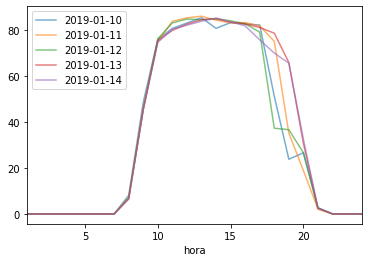

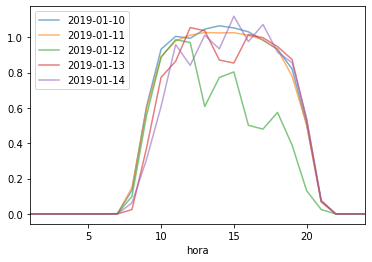

In [20]:
substation_plot("SE005T002", "gen_solar_total_mwh", ["2019-01-10","2019-01-11","2019-01-12","2019-01-13","2019-01-14"])
substation_plot("SE127T005", "gen_solar_total_mwh", ["2019-01-10","2019-01-11","2019-01-12","2019-01-13","2019-01-14"])

Los gráficos presentan la curva característica de la generación solar, sin producción en las horas sin luz y con un peak alrededor de las 3pm. Estos perfiles además incluyen el bloqueo del sol producto de nubes (también podrían deberse a mantenciones en secciones de la planta). Cabe destacar que las plantas más pequeñas están más expuestas a apagones producto de este tipo de interrupciones debido a que es altamente probable que una nube cubra toda la planta. Esto es ejemplificado en la segunda figura para la subestación SE127T005. Por otro lado, la subestación SE005T002 posee menos interrupciones. Ambas subestaciones proveen cerca de 13 horas de energía lo que es común para épocas de verano en Chile, Enero en este caso. Para invierno los perfiles debiesen ser un poco distintos, con más interrupciones, y menos horas solares.

## Punto 5

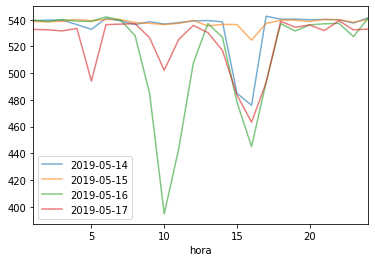

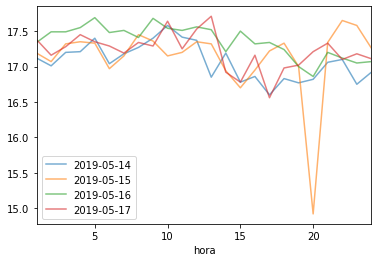

In [21]:
substation_plot("SE020G213", "gen_termica_total_mwh", ["2019-05-14","2019-05-15","2019-05-16","2019-05-17"])
substation_plot("SE106G216", "gen_termica_total_mwh", ["2019-05-14","2019-05-15","2019-05-16","2019-05-17"])

Los perfiles térmicos presentados muestran comportamientos típicos de centrales térmicas. Debido a su poca volatilidad (en contraste con energía solar por ejemplo) pueden mantener generación constante por todo el día tal como se ve para ambas subestaciones. Las variaciones son producto de variaciones en demanda (o mantenciones pero durarían por mucho más tiempo, no es el caso), donde la demanda baja y la energía de las plantas térmicas es menos requerida, prefiriendo mantener centrales de menor costo. La subestación SE020G213 incluye mucha más carga térmica en comparación con la subestación SE106G216.
Sería interesante contrastar con las otras tecnologías de generación para las mismas fecha.

# Pregunta 5

WARNING: el modelo para pronosticar desviaciones será aplicado en una subestación a le vez (en esta y las siguientes preguntas). La agregación de los resultados de todas las subestaciones no debiese ser tan complicada pero por temas de tiempo no se considerará.

## Punto 1, 2 y 3

In [22]:
base_pred["cmg_desv_cat"] = (abs(base_pred["cmg_desv_pct"]) > 15).astype(int)
base_pred["en_total_mwh"] = base_pred[["gen_eolica_total_mwh","gen_geotermica_total_mwh","gen_hidraulica_total_mwh","gen_solar_total_mwh","gen_termica_total_mwh"]].sum(axis=1)
base_pred_srtd = base_pred.sort_values(["nemotecnico_se", "fecha", "hora"]) # ordenamos datetimes para realizar lags

Por simplicidad, sólo se considerarán lags en las variables y se asumirá que se tienen valores hasta la hora anterior a la que se quiere predecir.

In [23]:
def add_lags(dataframe, cols_list, lag_dict, from_hour=0):
    """ Crea lags especificados en lag_dict (en horas) para columnas en cols_list
    params:
    dataframe: DataFrame. Bar should be already filtered.
    cols_list: List.
    lag_dict: Dictionary. key: lag in hours, value: name for lag
    """
    df2 = dataframe.copy()
    for lag in lag_dict:
        for col in cols_list:
            new_col = "{}-{}-{}".format(col, lag_dict[lag], from_hour)
            df2[new_col] = df2[col].shift(from_hour+lag)
    return df2

In [24]:
SELECTED_BAR = "SE005T002" # Para simplificar el modelo el forecating se hará por subestación, esta barra seleccionada es tomada como ejemplo
relevant_cols = ["hora", "month", "year_week", "year_day", "week_day", "is_weekend", "en_total_mwh", "demanda_mwh", "cmg_real", "cmg_prog", "cmg_desv", "cmg_desv_cat"]
cols_to_lag = ["en_total_mwh", "demanda_mwh", "cmg_real", "cmg_prog", "cmg_desv"] # columnas para lag
lags_dict = {1:"1d", 2:"2h", 3:"3h", 12:"12h", 24: "1d", 168: "1w", 720: "1m"} # lags a considerar en horas []

filtered_df = base_pred_srtd[base_pred_srtd["nemotecnico_se"] == SELECTED_BAR][relevant_cols]
new_df = add_lags(filtered_df, cols_to_lag, lags_dict) # se agregan lags
new_df = new_df.drop(columns=cols_to_lag) # se eliminan los valores de la hora actual considerando que se busca pronóstico para una hora (datos referente a la fecha y hora actual se asumen conocidos)
new_df = new_df.dropna() # se mantienen solo los datos completos

new_df.iloc[0:4]

,hora,month,year_week,year_day,week_day,is_weekend,cmg_desv_cat,en_total_mwh-1d-0,demanda_mwh-1d-0,cmg_real-1d-0,...,en_total_mwh-1w-0,demanda_mwh-1w-0,cmg_real-1w-0,cmg_prog-1w-0,cmg_desv-1w-0,en_total_mwh-1m-0,demanda_mwh-1m-0,cmg_real-1m-0,cmg_prog-1m-0,cmg_desv-1m-0
22533,1,1,5,31,3,0,1,0.0,634701.0,66.36,...,0.0,708706.0,56.82,56.823602,0.00,0.0,641755.0,54.28,126.784621,-72.50
22534,2,1,5,31,3,0,1,0.0,624177.0,56.28,...,0.0,695379.0,52.95,56.823602,-3.87,0.0,632049.0,54.28,127.609919,-73.33
22535,3,1,5,31,3,0,1,0.0,6280.0,53.92,...,0.0,697173.0,51.52,56.823602,-5.30,0.0,624261.0,54.28,53.299761,0.98
22536,4,1,5,31,3,0,1,0.0,625008.0,53.38,...,0.0,705597.0,51.52,56.813811,-5.29,0.0,638849.0,54.28,54.417801,-0.14


Como no se busca el mejor modelo (no se explicíta) se considera uno simple para predicción de variables categóricas como Logistic Regression. (Si se quiere explorar modelos más precisos Ensembled methods con técnicas boosting o bagging son una buena opción).

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

def transform_dataset(dataframe, target_col):
    """ Retorna conjuntos de training y test normalizados
    params:
    dataframe: DataFrame. Contiene variables dependientes e independiente
    target: String. Nombre de la variable independiente
    """
    filt = np.random.rand(len(dataframe)) < 0.8
    train = dataframe[filt]
    test = dataframe[~filt]
    col_indep = [c for c in dataframe.columns if c != target_col]

    x_train = train[col_indep]
    y_train = train[[target_col]]
    x_test = test[col_indep]
    y_test = test[[target_col]]

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    indep_scaler = scaler_x.fit(x_train)
    dep_scaler = scaler_y.fit(y_train)
    
    xtr_norm = indep_scaler.transform(x_train)
    ytr_norm = dep_scaler.transform(y_train)
    xte_norm = indep_scaler.transform(x_test)
    yte_norm = dep_scaler.transform(y_test)

    return xtr_norm, ytr_norm, xte_norm, yte_norm

x_train1, y_train1, x_test1, y_test1 = transform_dataset(new_df, "cmg_desv_cat") # se separan y normalizan los valores
model1 = LogisticRegression() # Crea el modelo
lreg1 = model1.fit(x_train1, y_train1) # Ajuste del modelo a los datos

Para evaluar el modelo se utiliza el área bajo la curva ROC (para modelos de clasificación), que compara verdaderos positivos (sensitivity) respecto de falsos postivos (1-sensitivity). Si la curva es recta, el modelo no es bueno. Mientras más se aleje de la recta mejor el modelo.

AUC: 0.642531907854643


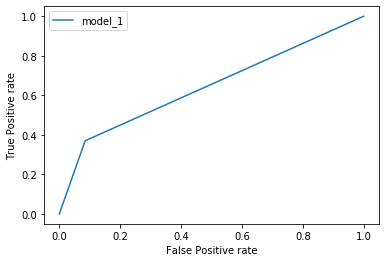

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
y_pred1 = lreg1.predict(x_test1)
fpr_1, tpr_1, _ = roc_curve(y_test1, y_pred1)
fig, ax = plt.subplots()
ax.plot(fpr_1, tpr_1, label='model_1')
ax.set_ylabel("True Positive rate")
ax.set_xlabel("False Positive rate")
ax.legend()
print("AUC: {}".format(roc_auc_score(y_test1, y_pred1)))

Como se puede ver, el resultado del AUC no es muy prometedor. Idealmente el AUC debiese estar cerca de 1, y lejos de 0.5 (bajo 0.5, el modelo es recíproco), mostrando una curva más pronunciada. Particularmente en este caso la clasificación es binaria por lo que la curva tendrá sólo un punto de inflexión.

Por otro lado, para ver la importancia de las variables, se analizan los coeficientes de la regresión, tal como se muestra a continuación:

In [27]:
# ¿Cuales son las variables más importantes que considera este modelo?
resume = pd.DataFrame()
resume["variable"] = [c for c in new_df.columns if c != "cmg_desv_cat"]
resume["coef"] = abs(model1.coef_[0])
print("Coeficientes mas importantes:")
print(resume.sort_values('coef', ascending=False).head(10))

Coeficientes mas importantes:
             variable      coef
1               month  2.587803
9       cmg_prog-1d-0  1.673500
15      cmg_desv-2h-0  1.513614
16  en_total_mwh-3h-0  1.232231
14      cmg_prog-2h-0  1.193467
11  en_total_mwh-2h-0  1.171164
6   en_total_mwh-1d-0  0.930415
20      cmg_desv-3h-0  0.909421
13      cmg_real-2h-0  0.791471
10      cmg_desv-1d-0  0.775747


Se muestran los 10 coeficientes más importantes y menos importantes. En este caso las variables más relevantes son principalmente los valores de las horas más cercanas, lo cual tiene bastante sentido. Además, era de esperar que depende en gran medida de los valores de horas anteriores del costo real y programado ya que de ellos es que se obtiene la variable dependiente. Es interesante que el mes tenga relevancia para el modelo.

# Pregunta 6

WARNING: No tengo experiencia con modelos multi-steps, pero esto es lo que se me ocurre

Si no se van a tener datos actualizados durante 12 horas, se deben utilizar los actuales para pronosticar 12 horas en adelante. La única información que si se va a tener es la de las fechas. Para esto se crea un modelo de regression para cada hora pronosticada:

In [28]:
ys_tested2 = []
ys_predicted2 = []
coefs = []
var_names = []
for last_hr in range(0,12):
    new_df2 = add_lags(filtered_df, cols_to_lag, lags_dict, from_hour=last_hr)
    new_df2 = new_df2.drop(columns=cols_to_lag)
    new_df2 = new_df2.dropna()
    x_train2, y_train2, x_test2, y_test2 = transform_dataset(new_df2, "cmg_desv_cat")
    model2 = LogisticRegression()
    lreg2 = model2.fit(x_train2, y_train2)
    y_pred2 = lreg2.predict(x_test2)
    ys_predicted2.append(y_pred2)
    ys_tested2.append(y_test2)
    coefs.append(model2.coef_[0])
    var_names.append(new_df2.columns)

AUC model1: 0.642531907854643
AUC model2: 0.59727566992779


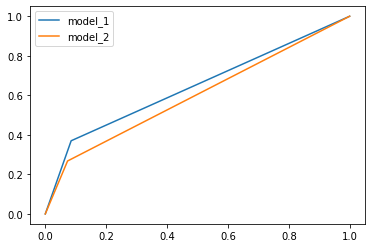

In [29]:
ys_t2 = np.concatenate(ys_tested2)
ys_p2 = np.concatenate(ys_predicted2)
fpr_2, tpr_2, _ = roc_curve(ys_t2, ys_p2)
fig, ax = plt.subplots()
ax.plot(fpr_1, tpr_1, label='model_1')
ax.plot(fpr_2, tpr_2, label='model_2')
ax.legend()
print("AUC model1: {}".format(roc_auc_score(y_test1, y_pred1)))
print("AUC model2: {}".format(roc_auc_score(ys_t2, ys_p2)))

Para comparar el modelo2 con el modelo1 también se utiliza la curva ROC y el AUC asociado. Aquí se puede ver que el modelo2 es peor que el modelo1. Esto se explica ya que mientras más alejados en el tiempo estén los valores a pronosticar, más dificil es obtener una buena predicción, por esto que el modelo2 ofrece un peor desempeño.

# Pregunta 7

In [30]:
clima = pd.read_csv(os.path.join(data_folder, "datos_clima.csv"))
clima.iloc[0:4]

,fecha,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06 00:00:00 UTC,SE019T002,-28.470641,-71.252694,2.0,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08 00:00:00 UTC,SE004T002,-39.549899,-72.912208,2.0,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97


En este caso, el data leakage se produce al tener datos resumen diarios en la hora 0 de cada día, lo que no tiene sentido. Considerando que aún se quieren obtener desviaciones horarias, una forma simple de lidiar con esto es realizar una interpolación considerando los valores diarios de clima.csv sólo en una hora específica del día (por ejemplo a mediodía o a medianoche). Esto sería una aporximación gruesa para incluir el clima en el model. Se elige la hora 12 de cada día para aplicar esto.

In [31]:
clima = clima.rename(columns={'subestacion': 'nemotecnico_se'})
clima["fecha"] = pd.to_datetime(clima["fecha"], format="%Y-%m-%d %H:%M:%S %Z")
clima["hora"] = 12
clima = clima.drop(columns=['lat','lon'])
base_pred_clima = pd.merge(base_pred_srtd, clima, how='left', left_on=['nemotecnico_se','fecha','hora'], right_on=['nemotecnico_se', 'fecha','hora'])
columns_to_interp = [c for c in clima.columns if c not in ['fecha', 'hora', 'nemotecnico_se']]
for se in base_pred_clima["nemotecnico_se"].unique():
    se_filter = base_pred_clima["nemotecnico_se"] == se
    base_pred_clima.loc[se_filter,columns_to_interp] = base_pred_clima[se_filter][columns_to_interp].interpolate(method='linear')
base_pred_clima.iloc[105:110]

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
105,SE001T002,2019-01-05 00:00:00+00:00,10,0.0,0.0,0.0,0.14,0.0,46.07,45.934566,...,27.894167,14.266667,1.456667,24.84000,3.300000,6.680000,0.565833,3.059167,5.594167,0.631667
106,SE001T002,2019-01-05 00:00:00+00:00,11,0.0,0.0,0.0,0.20,0.0,46.09,45.151247,...,27.892083,14.258333,1.453333,24.82500,3.300000,6.690000,0.577917,3.059583,5.602083,0.650833
107,SE001T002,2019-01-05 00:00:00+00:00,12,0.0,0.0,0.0,0.23,0.0,45.21,45.141751,...,27.890000,14.250000,1.450000,24.81000,3.300000,6.700000,0.590000,3.060000,5.610000,0.670000
108,SE001T002,2019-01-05 00:00:00+00:00,13,0.0,0.0,0.0,0.23,0.0,43.70,43.869908,...,27.790833,14.220000,1.440417,24.74375,3.324583,6.760833,0.578333,3.099167,5.699167,0.670000
109,SE001T002,2019-01-05 00:00:00+00:00,14,0.0,0.0,0.0,0.23,0.0,44.04,43.878123,...,27.691667,14.190000,1.430833,24.67750,3.349167,6.821667,0.566667,3.138333,5.788333,0.670000


In [32]:
relevant_cols2 = relevant_cols + columns_to_interp
cols_to_lag2 = cols_to_lag + columns_to_interp

# Preparar datos (PARA UNA SUBESTACION)
filtered_df2 = base_pred_clima[base_pred_clima["nemotecnico_se"] == SELECTED_BAR][relevant_cols2]

In [33]:
# Entrenar el modelo
ys_tested3 = []
ys_predicted3 = []
coefs3 = []
var_names3 = []
for last_hr in range(0,12):
    new_df3 = add_lags(filtered_df2, cols_to_lag2, lags_dict, from_hour=last_hr)
    new_df3 = new_df3.drop(columns=cols_to_lag2)
    new_df3 = new_df3.dropna()
    x_train3, y_train3, x_test3, y_test3 = transform_dataset(new_df3, "cmg_desv_cat")
    model3 = LogisticRegression()
    lreg3 = model3.fit(x_train3, y_train3)
    y_pred3 = lreg3.predict(x_test3)
    ys_predicted3.append(y_pred3)
    ys_tested3.append(y_test3)
    coefs3.append(model3.coef_[0])
    var_names3.append(new_df3.columns)

AUC model1: 0.642531907854643
AUC model2: 0.59727566992779
AUC model3: 0.6328249115187125


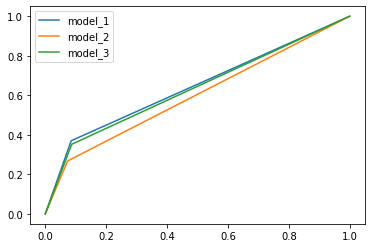

In [34]:
ys_t3 = np.concatenate(ys_tested3)
ys_p3 = np.concatenate(ys_predicted3)
fpr_3, tpr_3, _ = roc_curve(ys_t3, ys_p3)
fig, ax = plt.subplots()
ax.plot(fpr_1, tpr_1, label='model_1')
ax.plot(fpr_2, tpr_2, label='model_2')
ax.plot(fpr_3, tpr_3, label='model_3')
ax.legend()
print("AUC model1: {}".format(roc_auc_score(y_test1, y_pred1)))
print("AUC model2: {}".format(roc_auc_score(ys_t2, ys_p2)))
print("AUC model3: {}".format(roc_auc_score(ys_t3, ys_p3)))

Si bien la regresión utilizada no es la mejor para predicciones, la capacidad predictiva considerando los valores meteorológicos aumenta, incluso casi alcanzando al modelo1. Si bien, en términos generales no es un mejoramiento sustancial, muestra que los datos climáticos efectivamente ayudan a las predicciones. Mas aún, este resultado es relevante teniendo en cuenta que el modelo3 está pronosticando hasta 11 pasos adelante, mientras que el modelo1 es sólo un paso.

Para obtener la importancia de los coeficientes, se calcula su promedio entre todos los modelos (pronosticos) que consideran la variable asociada a ese coeficiente

In [35]:
resume2 = pd.DataFrame()
resume2["variable"] = [c for c in np.concatenate(var_names3) if c != "cmg_desv_cat"]
resume2["coef"] = np.concatenate(coefs3)
resume2 = abs(resume2.groupby('variable').mean())
print("Coeficientes mas importantes:")
print(resume2.sort_values('coef', ascending=False).head(20))

Coeficientes mas importantes:
                     coef
variable                 
KT-1w-5          2.658044
KT-1w-4          2.591956
KT-1w-6          2.584548
KT-1w-2          2.510495
KT-1w-9          2.374215
KT-1w-3          2.337442
KT-1w-8          2.303289
KT-1w-7          2.294576
KT-1w-0          2.280721
KT-1w-10         2.230028
KT-1w-1          2.190808
KT-1w-11         2.055489
cmg_real-1w-2    1.861536
WS10M_MAX-12h-7  1.806692
cmg_prog-1d-1    1.735574
cmg_prog-12h-11  1.720696
PRECTOT-1d-0     1.588705
WS10M_MAX-12h-6  1.578547
PRECTOT-1d-2     1.571428
cmg_prog-12h-10  1.557419


Es importante explicar el significado de los nombres de las variables. Por ejemplo, KT-1w-5 significa que, posicionándome en la hora actual (datos que actualmente tengo), se está pronosticando cmg_desv_cat 5 horas más adelante (rango en el cual no tengo datos), con un valor de hace 1 semana (1w) atrás de la variable KT.
Se puede ver que las variables más relevantes son las asociadas al clima, particularmente KT (insolation clearness index) tiene mucha relevancia para valores de hace una semana atrás en todos los pronósticos (desde 1 a 12 horas hacia adelante).

# Pregunta 8

El mercado eléctrico chileno se basa en ventas de paquetes de energía a precios fijados por contrato o a precio spot. Es en la decisión entre uno y otro donde cobra relevancia el poder predecir desvíos de precios, disminuyendo el riesgo compra o venta de energía. Otro ejemplo se evidencia en el operador de sistema, quién busca operar lo más económicamente posible. Al poder preveer comportamientos más costosos en la red, puede tomar medidas precautorias para dimsinuirlos (como por ejemplo disminuir congestiones en transmisión cercana a los puntos más caros). Por otro lado, actualmente la apertura del mercado eléctrico chileno es prácticamente inminente, dando paso a nuevos agentes. Particularmente, los comercializadores son entes que hacen contratos directos con la demanda (casas). Ellos, a través del manejo de la demanda, ofrecen flexibilidad a la red que es pagada por el operador de red. La desviación de precios es una señal importante para ellos para saber cuando participar y en cuanto se estaría avaluando su energía. Estos son algunos ejemplos que son posibles de aplicar en Chile donde el uso del pronóstico de la desviación de precios es relevante.
